In [1]:
! pip install imbalanced-learn

     |████████████████████████████████| 167 kB 4.9 MB/s eta 0:00:01
You should consider upgrading via the '/home/ec2-user/anaconda3/envs/python3/bin/python -m pip install --upgrade pip' command.


In [40]:
! pip install shap

     |████████████████████████████████| 319 kB 4.4 MB/s eta 0:00:01
  Created wheel for shap: filename=shap-0.36.0-cp36-cp36m-linux_x86_64.whl size=439797 sha256=f9bb56e59614c0d50ebd9738debe5d9ab5f0b25054b307f824483a379c3914c2
  Stored in directory: /home/ec2-user/.cache/pip/wheels/13/25/e6/7510ba3a400c62b74e62118de280be871af157dac83efc71c8
Successfully built shap
You should consider upgrading via the '/home/ec2-user/anaconda3/envs/python3/bin/python -m pip install --upgrade pip' command.


In [1]:
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib as mpl
import matplotlib.pyplot as plt
from zipfile import ZipFile
from pandas.api.types import CategoricalDtype
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler, MinMaxScaler
from sklearn.feature_selection import VarianceThreshold, chi2, SelectKBest, mutual_info_classif
from sklearn.preprocessing import MinMaxScaler
from sklearn.linear_model import LogisticRegression
from sklearn.pipeline import Pipeline
#from imblearn.over_sampling import RandomOverSampler
from sklearn import metrics
#from xgboost import XGBClassifier
from sklearn.model_selection import train_test_split
from sklearn.linear_model import SGDClassifier
from sklearn.impute import SimpleImputer
from sklearn.model_selection import GridSearchCV
from sklearn.ensemble import RandomForestClassifier
import sklearn.metrics as skm
import itertools
from sklearn.metrics import confusion_matrix, recall_score, precision_score, roc_auc_score, roc_curve
pd.set_option('display.max_colwidth', 900, 'display.max_rows', None, 'display.max_columns', None)
%matplotlib inline

In [20]:
#Download from github repo
!wget -N https://github.com/joechoong33/LC_loan/zipball/master
!unzip -o master
!unzip -o joechoong33-LC_loan-70a9ba3/DS-02-lendingclub-loan-data-2017q1.zip

--2020-09-25 04:49:48--  https://github.com/joechoong33/LC_loan/zipball/master
Resolving github.com (github.com)... 192.30.255.112
Connecting to github.com (github.com)|192.30.255.112|:443... connected.
HTTP request sent, awaiting response... 302 Found
Location: https://codeload.github.com/joechoong33/LC_loan/legacy.zip/master [following]
--2020-09-25 04:49:48--  https://codeload.github.com/joechoong33/LC_loan/legacy.zip/master
Resolving codeload.github.com (codeload.github.com)... 192.30.255.121
Connecting to codeload.github.com (codeload.github.com)|192.30.255.121|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: unspecified [application/zip]
Saving to: ‘master’

master                  [      <=>           ]  30.88M  29.6MB/s    in 1.0s    

Last-modified header missing -- time-stamps turned off.
2020-09-25 04:49:50 (29.6 MB/s) - ‘master’ saved [32385856]

Archive:  master
ecae133802241a816be9b593246ea89fe52caaca
 extracting: joechoong33-LC_loan-ecae133/DS-02

In [2]:
df = pd.read_csv('lpetrocelli-lendingclub-loan-data-2017-q-1/LoanStats_2017Q1 2.csv',skiprows = 1)
df.shape

/home/ec2-user/anaconda3/envs/python3/lib/python3.6/site-packages/IPython/core/interactiveshell.py:3063: DtypeWarning: Columns (0,112) have mixed types.Specify dtype option on import or set low_memory=False.
  interactivity=interactivity, compiler=compiler, result=result)


(96781, 122)

In [3]:
# Read from S3
#filepath = 'https://joe1970.s3-ap-southeast-1.amazonaws.com/'
#df = pd.read_csv(filepath + 'LoanStats_2017Q1+2.csv',skiprows=1)
#df.shape

In [4]:
df_loan = df[:-2]
df_loan.tail(2)

df['int_rate'] = df['int_rate'].str.replace('%','')

df['int_rate'] = pd.to_numeric(df['int_rate'],errors='coerce')

In [5]:
# Categorize employment length
def emp_to_num(term):
    if pd.isna(term):
        return None
    elif term[2]=='+':
        return 10
    elif term[0]=='<':
        return 0
    else:
        return int(term[0])

df['emp_length_num'] = df['emp_length'].apply(emp_to_num)

In [6]:
#Feature engineer - basically lender credit status
df.loc[:, 'flag'] = np.where((df.purpose == 'debt_consolidation') | (df.purpose == 'credit_card'),1.0, -1.0)
df['install_loan_ratio'] = (df['installment'] / df['loan_amnt']) * 100

In [7]:
df['long_emp'] = df['emp_length'].apply(lambda x: 1*(x=='10+ years'))
df['short_emp'] = df['emp_length'].apply(lambda x: 1*(x=='1 year' or x=='< 1 year'))


In [8]:
df['loan_status'].value_counts()

Current               78897
Issued                15071
Fully Paid             2251
In Grace Period         330
Late (31-120 days)      126
Late (16-30 days)       104
Name: loan_status, dtype: int64

In [9]:
#Predict for low risk and high risk - map loan status into 0 and 1
df['target']=df['loan_status'].map({'Current': 1,'Issued': 1, 'Fully Paid': 1, 'In Grace Period': 0, 'Late (31-120 days)':0, 'Late (16-30 days)': 0})

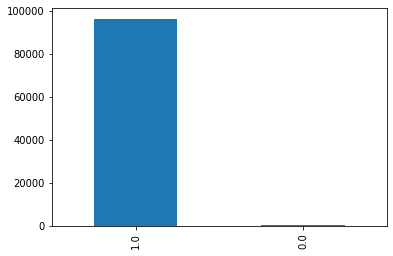

In [10]:
# Huge class imbalance
df['target'].value_counts().plot(kind='bar')

In [11]:
df['target'].value_counts(normalize=True)

1.0    0.994214
0.0    0.005786
Name: target, dtype: float64

In [12]:
#tranform annual income to log
df['annual_inc_log'] = df['annual_inc'].apply(np.log)

In [13]:
# Use attributes that have less missing values and investors can understand
columns = ['loan_amnt', 'term', 'int_rate','flag','install_loan_ratio',
       'installment', 'grade', 'emp_length',
       'home_ownership', 'annual_inc_log', 'verification_status',
       'target', 'purpose',
       'addr_state', 'dti', 'delinq_2yrs',
       'inq_last_6mths', 'open_acc',
       'pub_rec', 'revol_bal', 'revol_util', 'total_acc']
df = df[columns]

df.dropna(inplace=True)

In [14]:
# Label encode grade
from sklearn import preprocessing 
label_encoder = preprocessing.LabelEncoder()
df['grade']= label_encoder.fit_transform(df['grade']) 
df['grade'].unique()

array([0, 2, 1, 4, 3, 5, 6])

In [14]:
# Map grade to numeric category
#df['grade']=df['grade'].map({'A': 1, 'B': 2, 'C': 3, 'D': 4, 'E': 5, 'F': 6, 'G': 7})

In [15]:
#Copy dataframe
df_dummies = pd.get_dummies(df) 
drop_columns = df_dummies.columns[(df_dummies.mean()<0.01)]
df_dummies.drop(drop_columns, axis=1, inplace=True)
df_dummies['verification_status_Verified_sum'] = df_dummies['verification_status_Source Verified']+df_dummies['verification_status_Verified']
df_dummies.drop(['verification_status_Source Verified', 'verification_status_Verified'], axis=1, inplace=True)
df_dummies = df_dummies.rename(columns={'emp_length_10+ years':'emp_length_10 years','emp_length_< 1 year':'emp_length_less 1 year'})

In [16]:
df_dummies.head(3)

,loan_amnt,int_rate,flag,install_loan_ratio,installment,grade,target,dti,delinq_2yrs,inq_last_6mths,open_acc,pub_rec,revol_bal,total_acc,term_ 36 months,term_ 60 months,emp_length_1 year,emp_length_10 years,emp_length_2 years,emp_length_3 years,emp_length_4 years,emp_length_5 years,emp_length_6 years,emp_length_7 years,emp_length_8 years,emp_length_9 years,emp_length_less 1 year,home_ownership_MORTGAGE,home_ownership_OWN,home_ownership_RENT,verification_status_Not Verified,purpose_car,purpose_credit_card,purpose_debt_consolidation,purpose_home_improvement,purpose_major_purchase,purpose_medical,purpose_other,purpose_small_business,addr_state_AL,addr_state_AZ,addr_state_CA,addr_state_CO,addr_state_CT,addr_state_FL,addr_state_GA,addr_state_IL,addr_state_IN,addr_state_LA,addr_state_MA,addr_state_MD,addr_state_MI,addr_state_MN,addr_state_MO,addr_state_NC,addr_state_NJ,addr_state_NV,addr_state_NY,addr_state_OH,addr_state_OR,addr_state_PA,addr_state_SC,addr_state_TN,addr_state_TX,addr_state_VA,addr_state_WA,addr_state_WI,verification_status_Verified_sum
0,3600.0,7.49,-1.0,3.110278,111.97,0,1.0,18.90,0.0,1.0,18.0,1.0,5658.0,33.0,1,0,0,1,0,0,0,0,0,0,0,0,0,1,0,0,1,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
1,15000.0,14.99,-1.0,2.378533,356.78,2,1.0,17.25,0.0,0.0,11.0,0.0,53167.0,18.0,0,1,0,1,0,0,0,0,0,0,0,0,0,1,0,0,1,0,0,0,0,0,0,1,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
2,8400.0,11.39,-1.0,3.292381,276.56,1,1.0,15.63,0.0,0.0,14.0,0.0,12831.0,30.0,1,0,0,0,0,0,0,0,0,0,1,0,0,1,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,1


In [17]:
# After cleaning, prepare training data
X = df_dummies.drop('target', axis=1)
y = df_dummies['target']
X.shape

(89940, 67)

In [18]:
X.columns

Index(['loan_amnt', 'int_rate', 'flag', 'install_loan_ratio', 'installment',
       'grade', 'dti', 'delinq_2yrs', 'inq_last_6mths', 'open_acc', 'pub_rec',
       'revol_bal', 'total_acc', 'term_ 36 months', 'term_ 60 months',
       'emp_length_1 year', 'emp_length_10 years', 'emp_length_2 years',
       'emp_length_3 years', 'emp_length_4 years', 'emp_length_5 years',
       'emp_length_6 years', 'emp_length_7 years', 'emp_length_8 years',
       'emp_length_9 years', 'emp_length_less 1 year',
       'home_ownership_MORTGAGE', 'home_ownership_OWN', 'home_ownership_RENT',
       'verification_status_Not Verified', 'purpose_car',
       'purpose_credit_card', 'purpose_debt_consolidation',
       'purpose_home_improvement', 'purpose_major_purchase', 'purpose_medical',
       'purpose_other', 'purpose_small_business', 'addr_state_AL',
       'addr_state_AZ', 'addr_state_CA', 'addr_state_CO', 'addr_state_CT',
       'addr_state_FL', 'addr_state_GA', 'addr_state_IL', 'addr_state_IN',
     

In [19]:
#Drop zip code of states
drop_list1 = ['addr_state_AL',
       'addr_state_AZ', 'addr_state_CA', 'addr_state_CO', 'addr_state_CT',
       'addr_state_FL', 'addr_state_GA', 'addr_state_IL', 'addr_state_IN',
       'addr_state_LA', 'addr_state_MA', 'addr_state_MD', 'addr_state_MI',
       'addr_state_MN', 'addr_state_MO', 'addr_state_NC', 'addr_state_NJ',
       'addr_state_NV', 'addr_state_NY', 'addr_state_OH', 'addr_state_OR',
       'addr_state_PA', 'addr_state_SC', 'addr_state_TN', 'addr_state_TX',
       'addr_state_VA', 'addr_state_WA', 'addr_state_WI']

X.drop(drop_list1,axis=1,inplace=True)

In [20]:
# Build train and test set > 80:20
from sklearn.model_selection import train_test_split
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2,stratify = y,random_state=0) #0 6 = 0.698

In [21]:
X_train.head(2)

,loan_amnt,int_rate,flag,install_loan_ratio,installment,grade,dti,delinq_2yrs,inq_last_6mths,open_acc,pub_rec,revol_bal,total_acc,term_ 36 months,term_ 60 months,emp_length_1 year,emp_length_10 years,emp_length_2 years,emp_length_3 years,emp_length_4 years,emp_length_5 years,emp_length_6 years,emp_length_7 years,emp_length_8 years,emp_length_9 years,emp_length_less 1 year,home_ownership_MORTGAGE,home_ownership_OWN,home_ownership_RENT,verification_status_Not Verified,purpose_car,purpose_credit_card,purpose_debt_consolidation,purpose_home_improvement,purpose_major_purchase,purpose_medical,purpose_other,purpose_small_business,verification_status_Verified_sum
43830,18000.0,5.32,1.0,3.011500,542.07,0,18.19,0.0,0.0,10.0,0.0,28966.0,20.0,1,0,0,1,0,0,0,0,0,0,0,0,0,1,0,0,1,0,1,0,0,0,0,0,0,0
51874,14000.0,14.99,1.0,3.466071,485.25,2,24.77,0.0,0.0,8.0,3.0,6506.0,24.0,1,0,1,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,1,0,0,0,0,0,1


In [26]:
#train = pd.concat([X_train,y_train],axis=1)
#test = pd.concat([X_test,y_test],axis=1)
#train.to_csv('train.csv',index=False,header=False)
#test.to_csv('test.csv',index=False,header=False)

In [22]:
# Baseline model random forest
pipeline_rfc = Pipeline([
    ('imputer', SimpleImputer(copy=False)),
    ('model', RandomForestClassifier(n_jobs=-1, random_state=1))
])
param_grid_rfc = {
    'model__n_estimators': [10,30,100] # The number of randomized trees to build
}
grid_rfc = GridSearchCV(estimator=pipeline_rfc, param_grid=param_grid_rfc, scoring='roc_auc', n_jobs=1, pre_dispatch=1, cv=5, verbose=1, return_train_score=False)
grid_rfc.fit(X_train, y_train)

Fitting 5 folds for each of 3 candidates, totalling 15 fits


[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done  15 out of  15 | elapsed:   31.8s finished


GridSearchCV(cv=5,
             estimator=Pipeline(steps=[('imputer', SimpleImputer(copy=False)),
                                       ('model',
                                        RandomForestClassifier(n_jobs=-1,
                                                               random_state=1))]),
             n_jobs=1, param_grid={'model__n_estimators': [10, 30, 100]},
             pre_dispatch=1, scoring='roc_auc', verbose=1)

In [23]:
y_rf_pred = grid_rfc.predict_proba(X_test)[:,1]
roc_auc_score(y_test, y_rf_pred)

0.5570052465726283

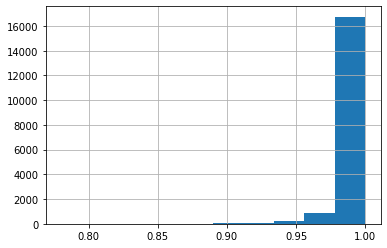

In [24]:
P = pd.Series(y_rf_pred)
P.hist()

In [25]:
P.describe()

count    17988.000000
mean         0.993539
std          0.013073
min          0.780000
25%          0.990000
50%          1.000000
75%          1.000000
max          1.000000
dtype: float64

ROC-AUC-score:  0.5570052465726283


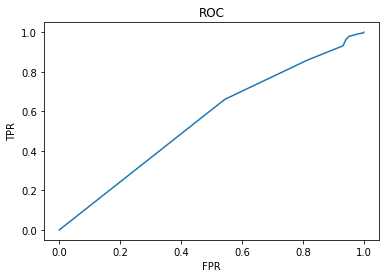

In [26]:
fpr, tpr, tresholds = roc_curve(y_test, y_rf_pred)
plt.plot(fpr, tpr)
plt.title('ROC')
plt.xlabel('FPR')
plt.ylabel('TPR')

print('ROC-AUC-score: ', roc_auc_score(y_test, y_rf_pred))

In [27]:
grid_rfc.best_params_

{'model__n_estimators': 100}

ROC-AUC-score:  0.6950815756546002


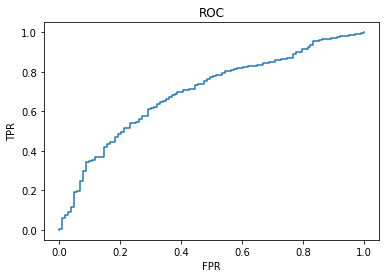

In [28]:
# Train and Predict with logistic regression
sc = MinMaxScaler()
clf = LogisticRegression(penalty='l2', C=0.01)

pipe_lr = Pipeline([('scaler', sc), ('clf', clf)])
pipe_lr.fit(X_train, y_train)

y_pred_lr = pipe_lr.predict_proba(X_test)[:,1]
fpr, tpr, tresholds = roc_curve(y_test, y_pred_lr)
plt.plot(fpr, tpr)
plt.title('ROC')
plt.xlabel('FPR')
plt.ylabel('TPR')

print('ROC-AUC-score: ', roc_auc_score(y_test, y_pred_lr))

In [29]:
# Finetune and grid search with logistic regression

# Best
pipeline_sgdlogreg = Pipeline([
    ('imputer', SimpleImputer(copy=False)), # Mean imputation by default
    ('scaler', StandardScaler(copy=False)),
    ('model', SGDClassifier(loss='log', max_iter=1000, tol=1e-3, random_state=1, warm_start=True))
])
param_grid_sgdlogreg = {
    'model__alpha': [10**-5, 10**-2, 10**1],
    'model__penalty': ['l1', 'l2']
}
param_grid_sgdlogreg = {
    'model__alpha': np.logspace(-4.5, 0.3, 11), # Fills in the gaps between 10^-5 and 10^1
    'model__penalty': ['l1', 'l2']
}

grid_sgdlogreg = GridSearchCV(estimator=pipeline_sgdlogreg, param_grid=param_grid_sgdlogreg, scoring='roc_auc', n_jobs=-1, pre_dispatch=1, cv=5, verbose=1, return_train_score=False)


In [30]:
grid_sgdlogreg.fit(X_train, y_train)

Fitting 5 folds for each of 22 candidates, totalling 110 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 2 concurrent workers.
[Parallel(n_jobs=-1)]: Done  49 tasks      | elapsed:   52.0s
[Parallel(n_jobs=-1)]: Done 110 out of 110 | elapsed:  1.3min finished


GridSearchCV(cv=5,
             estimator=Pipeline(steps=[('imputer', SimpleImputer(copy=False)),
                                       ('scaler', StandardScaler(copy=False)),
                                       ('model',
                                        SGDClassifier(loss='log',
                                                      random_state=1,
                                                      warm_start=True))]),
             n_jobs=-1,
             param_grid={'model__alpha': array([3.16227766e-05, 9.54992586e-05, 2.88403150e-04, 8.70963590e-04,
       2.63026799e-03, 7.94328235e-03, 2.39883292e-02, 7.24435960e-02,
       2.18776162e-01, 6.60693448e-01, 1.99526231e+00]),
                         'model__penalty': ['l1', 'l2']},
             pre_dispatch=1, scoring='roc_auc', verbose=1)

ROC-AUC-score:  0.7066636629382435


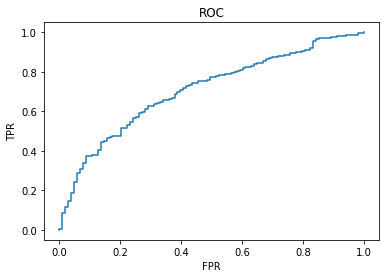

In [31]:
y_lr_grid = grid_sgdlogreg.predict_proba(X_test)[:,1]
roc_auc_score(y_test, y_lr_grid)

fpr, tpr, tresholds = roc_curve(y_test, y_lr_grid)
plt.plot(fpr, tpr)
plt.title('ROC')
plt.xlabel('FPR')
plt.ylabel('TPR')

print('ROC-AUC-score: ', roc_auc_score(y_test, y_lr_grid))

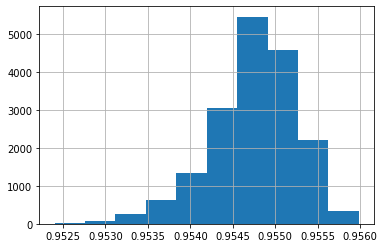

In [32]:
P = pd.Series(y_lr_grid)
P.hist()

In [33]:
# Get LR best parameter to train new lr model
grid_sgdlogreg.best_params_

{'model__alpha': 0.6606934480075964, 'model__penalty': 'l2'}

In [34]:
best_logReg = grid_sgdlogreg.best_estimator_
print(best_logReg.score(X_test,y_test))

0.9942739604180565


In [36]:
# Train lr to get co efficient
lr = LogisticRegression(penalty='l2', C=0.66)
lr.fit(X_train, y_train)
print(lr.score(X_test,y_test))

0.9942739604180565


/home/ec2-user/anaconda3/envs/python3/lib/python3.6/site-packages/sklearn/linear_model/_logistic.py:764: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  extra_warning_msg=_LOGISTIC_SOLVER_CONVERGENCE_MSG)


In [37]:
# Explain model with logistic regression
full_col_names = X.columns

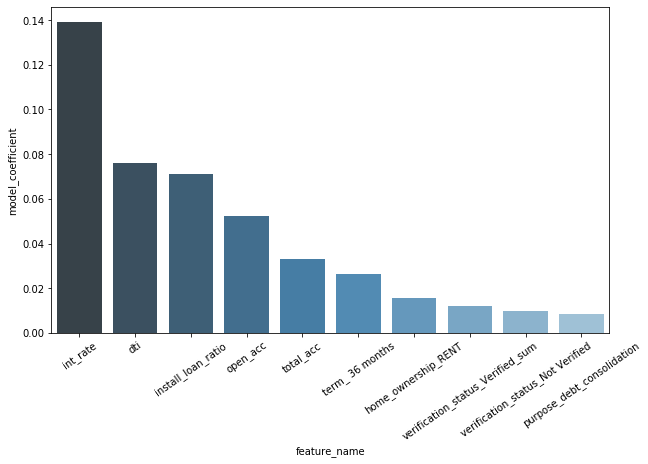

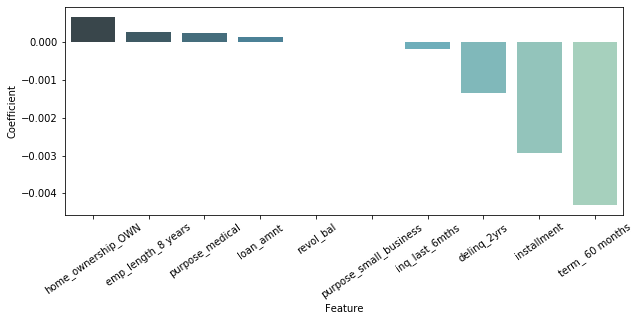

In [38]:
logReg_coeff = pd.DataFrame({'feature_name': full_col_names, 'model_coefficient': lr.coef_.transpose().flatten()})
logReg_coeff = logReg_coeff.sort_values('model_coefficient',ascending=False)
logReg_coeff_top = logReg_coeff.head(10)
logReg_coeff_bottom = logReg_coeff.tail(10)
# Plot top 5 coefficients
plt.figure().set_size_inches(10, 6)
fg3 = sns.barplot(x='feature_name', y='model_coefficient',data=logReg_coeff_top, palette="Blues_d")
fg3.set_xticklabels(rotation=35, labels=logReg_coeff_top.feature_name)
# Plot bottom 5 coefficients
plt.figure().set_size_inches(10,6)
fg4 = sns.barplot(x='feature_name', y='model_coefficient',data=logReg_coeff_bottom, palette="GnBu_d")
fg4.set_xticklabels(rotation=35, labels=logReg_coeff_bottom.feature_name)
plt.xlabel('Feature')
plt.ylabel('Coefficient')
plt.subplots_adjust(bottom=0.4)
#plt.savefig('figure_4.png')


In [41]:
# Explain model with Shap
import shap
explainer = shap.LinearExplainer(lr, X_train, feature_dependence="independent")

The option feature_dependence has been renamed to feature_perturbation!
The option feature_perturbation="independent" is has been renamed to feature_perturbation="interventional"!


In [42]:
shap_values = explainer.shap_values(X_test)
#X_test_array = X_test.toarray()

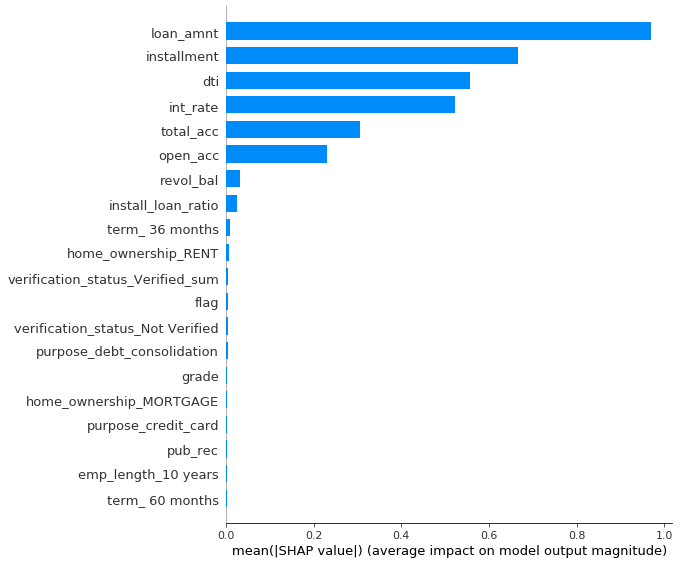

In [43]:
shap.summary_plot(shap_values, X_train, plot_type="bar")

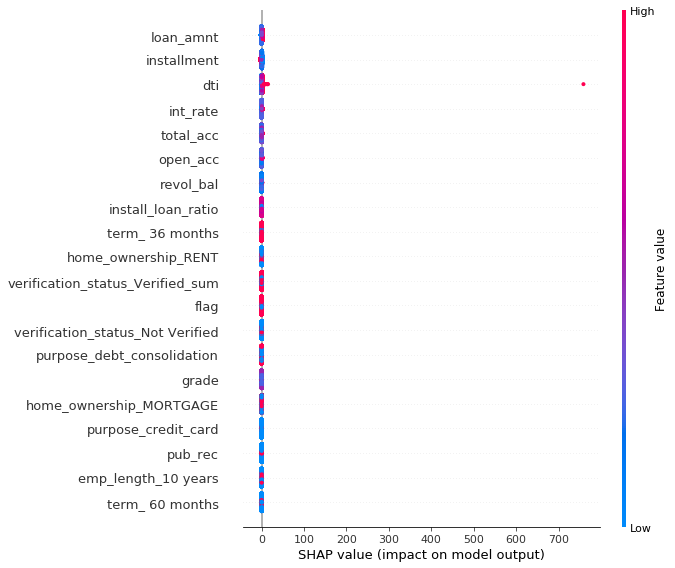

In [44]:
shap.summary_plot(shap_values, X_test)

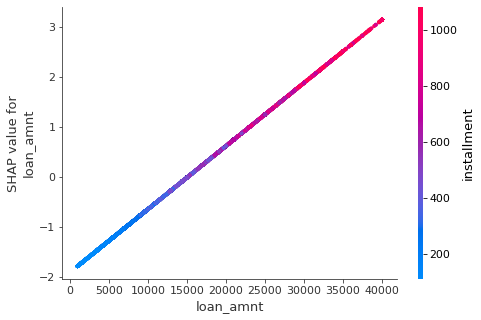

In [45]:
shap.dependence_plot('loan_amnt', shap_values, X_test)

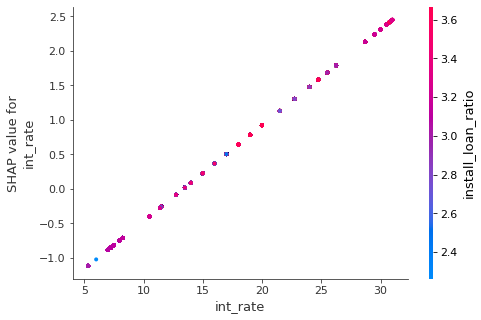

In [46]:
shap.dependence_plot('int_rate', shap_values, X_test)

In [37]:
#Trying smote technique for class imbalance
from imblearn.under_sampling import RandomUnderSampler
underSampler = RandomUnderSampler(sampling_strategy=0.2,random_state=1101) #1000 =0.7139

X_resampled, y_resampled = underSampler.fit_resample(X_train, y_train)
y_resampled.value_counts()

1.0    2065
0.0     413
Name: target, dtype: int64

In [38]:
grid_sgdlogreg.fit(X_resampled, y_resampled)

Fitting 5 folds for each of 22 candidates, totalling 110 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 2 concurrent workers.
[Parallel(n_jobs=-1)]: Done 110 out of 110 | elapsed:    4.2s finished


GridSearchCV(cv=5,
             estimator=Pipeline(steps=[('imputer', SimpleImputer(copy=False)),
                                       ('scaler', StandardScaler(copy=False)),
                                       ('model',
                                        SGDClassifier(loss='log',
                                                      random_state=1,
                                                      warm_start=True))]),
             n_jobs=-1,
             param_grid={'model__alpha': array([3.16227766e-05, 9.54992586e-05, 2.88403150e-04, 8.70963590e-04,
       2.63026799e-03, 7.94328235e-03, 2.39883292e-02, 7.24435960e-02,
       2.18776162e-01, 6.60693448e-01, 1.99526231e+00]),
                         'model__penalty': ['l1', 'l2']},
             pre_dispatch=1, scoring='roc_auc', verbose=1)

ROC-AUC-score:  0.7136370175148128


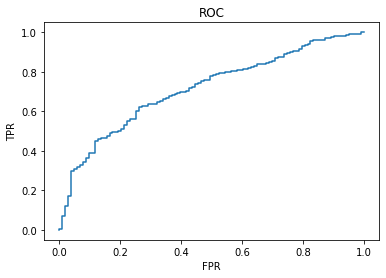

In [39]:
y_lr_grid_smote = grid_sgdlogreg.predict_proba(X_test)[:,1]
roc_auc_score(y_test, y_lr_grid_smote)
fpr, tpr, tresholds = roc_curve(y_test, y_lr_grid_smote)
plt.plot(fpr, tpr)
plt.title('ROC')
plt.xlabel('FPR')
plt.ylabel('TPR')

print('ROC-AUC-score: ', roc_auc_score(y_test, y_lr_grid_smote))

In [46]:
y_lr_grid_smote = np.where(y_lr_grid_smote > 0.5, 1, 0)
y_lr_grid = np.where(y_lr_grid > 0.5, 1, 0)

In [48]:
y_lr_grid[:100]

array([0.95294288, 0.95511372, 0.95501438, 0.95540895, 0.95402094,
       0.95490634, 0.95445543, 0.9542572 , 0.95498842, 0.95430758,
       0.95458727, 0.95483255, 0.95485367, 0.95555511, 0.95417669,
       0.9547194 , 0.95551999, 0.95537997, 0.95557408, 0.95498852,
       0.95574036, 0.95445863, 0.95386127, 0.95414188, 0.95533007,
       0.95479531, 0.95540644, 0.95503192, 0.95472145, 0.95434067,
       0.95430041, 0.95460291, 0.95453156, 0.95489234, 0.95453424,
       0.95515007, 0.95502144, 0.95530982, 0.95452889, 0.95552513,
       0.95548923, 0.95434049, 0.95515608, 0.95523685, 0.95339069,
       0.95475371, 0.95564611, 0.95465664, 0.95326303, 0.95503002,
       0.95501098, 0.95440467, 0.95525645, 0.95438618, 0.95554508,
       0.95510517, 0.95433082, 0.95423691, 0.95548687, 0.95460005,
       0.95462564, 0.95499451, 0.95334049, 0.95458794, 0.95500336,
       0.95449837, 0.95429997, 0.95407789, 0.95530992, 0.95351531,
       0.95518668, 0.95319262, 0.95414325, 0.95567398, 0.95457

In [50]:
# Build confusion matrix
y_lr_grid = np.where(y_lr_grid > 0.5, 1, 0)

In [54]:
import itertools
from sklearn.metrics import confusion_matrix, recall_score, precision_score
def plot_confusion_matrix(cm, classes,
                          normalize=False,
                          title='Confusion matrix',
                          cmap=plt.cm.Blues):
    """
    This function prints and plots the confusion matrix.
    Normalization can be applied by setting `normalize=True`.
    """
    if normalize:
        cm = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]
        print("Normalized confusion matrix")
    else:
        print('Confusion matrix, without normalization')

    print(cm)

    plt.imshow(cm, interpolation='nearest', cmap=cmap)
    plt.title(title)
    plt.colorbar()
    tick_marks = np.arange(len(classes))
    plt.xticks(tick_marks, classes, rotation=45)
    plt.yticks(tick_marks, classes)

    fmt = '.5f' if normalize else 'd'
    thresh = cm.max() / 2.
    for i, j in itertools.product(range(cm.shape[0]), range(cm.shape[1])):
        plt.text(j, i, format(cm[i, j], fmt),
                 horizontalalignment="center",
                 color="white" if cm[i, j] > thresh else "black")

    plt.tight_layout()
    plt.ylabel('True label')
    plt.xlabel('Predicted label')

Confusion matrix, without normalization
[[    0     0]
 [  103 17885]]
Normalized confusion matrix
[[ nan  nan]
 [0.01 0.99]]


invalid value encountered in true_divide


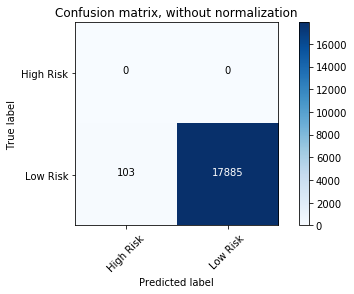

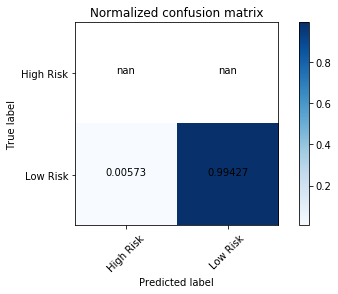

In [55]:
target_names = ['High Risk','Low Risk']
cnf_matrix = confusion_matrix(y_lr_grid,y_test)
np.set_printoptions(precision=2)

# Plot non-normalized confusion matrix
plt.figure()
plot_confusion_matrix(cnf_matrix, classes=target_names,
                      title='Confusion matrix, without normalization')

# Plot normalized confusion matrix
plt.figure()
plot_confusion_matrix(cnf_matrix, classes=target_names, normalize=True,
                      title='Normalized confusion matrix')

plt.show()